In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import requests

spotify_data = pd.read_csv("Resources/data.csv")

spot_data = pd.DataFrame(spotify_data)

spot_data.head()



,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [2]:
spot_data.columns

drop_columns = ['acousticness', 'duration_ms', 'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'speechiness', 'tempo',
       'valence']
clean_spot = spot_data.drop(columns=drop_columns)

clean_spot = clean_spot.rename(columns={"artists":"Artist","danceability":"Danceability","explicit":"Explicit","name":"Song Name","popularity":"Popularity","release_date":"Release Date","year":"Release Year"})

clean_spot["Danceability"] = clean_spot["Danceability"]*100

# clean_spot["Danceability"] = clean_spot["Danceability"].map("{0:,.2f}%".format)
# # clean_spot["Danceability"] = clean_spot["Danceability"].map("{0:,.2f}$".format)*100

clean_spot.head()

,Artist,Danceability,Explicit,Song Name,Popularity,Release Date,Release Year
0,['Mamie Smith'],59.8,0,Keep A Song In Your Soul,12,1920,1920
1,"[""Screamin' Jay Hawkins""]",85.2,0,I Put A Spell On You,7,1920-01-05,1920
2,['Mamie Smith'],64.7,0,Golfing Papa,4,1920,1920
3,['Oscar Velazquez'],73.0,0,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,1920
4,['Mixe'],70.4,1,Xuniverxe,2,1920-10-01,1920


In [3]:
#Get Artists Names & Popularity, and Dancability Columns
#Get Song titles, Popularity and Danceability Columns


#Groupby Artist Name, Sort by Popularity
#Groupby Song Title, Sort by Popularity

#Groupby Artist Name, Sort by Danceability
#Groupby Song Title, Sort by Danceability

#Find the relationship between Explicit & Popularity of an artist and a song

#Groupby Explicit, sorty by Popularity of an Artist
#Groupby Explicit, sorty by Popularity of an Song

artist_names = spot_data["artists"]


In [4]:
#Groupby year and plot a line graph of mean danceability and popularity over time

grouped_year = clean_spot.groupby(["Release Year"])
grouped_year.dtypes

year_df = pd.DataFrame({"Danceability": grouped_year["Danceability"].mean(),
                       "Popularity": grouped_year["Popularity"].mean()})
year_df

,Danceability,Popularity
Release Year,,
1920,51.575014,0.610315
1921,43.217051,0.391026
1922,57.561983,0.090909
1923,57.734054,5.205405
1924,54.989407,0.661017
...,...,...
2017,58.047519,31.662338
2018,60.273091,27.599484
2019,60.310142,32.346930


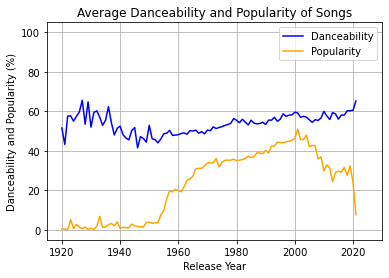

In [5]:
x_axis = np.arange(1920, 2022, 1)
dance_points = year_df["Danceability"]
pop_points = year_df["Popularity"]

dance_plot = plt.plot(x_axis, dance_points, color="blue", label="Danceability")
pop_plot = plt.plot(x_axis, pop_points, color="orange", label="Popularity")
plt.xlim(1915, 2030)
plt.ylim(-5, 105)
plt.xlabel("Release Year")
plt.ylabel("Danceability and Popularity (%)")
plt.title("Average Danceability and Popularity of Songs")
plt.legend(labels=["Danceability", "Popularity"], loc="best")
plt.grid()
plt.savefig("Images/DancePopOverTime.png")
plt.show()